# Elastic Net - Best of Both Worlds

Combining L1 (Lasso) and L2 (Ridge) regularization.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet as SKElasticNet, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
np.random.seed(42)

---
## Elastic Net Class

In [2]:
class ElasticNet:
    """
    Elastic Net: L1 + L2 regularization
    
    Cost = MSE + λ * [α * |w| + (1-α) * w²]
    """
    def __init__(self, alpha=1.0, l1_ratio=0.5, max_iter=1000, tol=1e-4):
        self.alpha = alpha  # Overall regularization strength
        self.l1_ratio = l1_ratio  # Mix: 0=Ridge, 1=Lasso
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.bias = None
    
    def _soft_threshold(self, rho, lambda_):
        if rho < -lambda_:
            return rho + lambda_
        elif rho > lambda_:
            return rho - lambda_
        else:
            return 0
    
    def fit(self, X, y):
        m, n = X.shape
        
        # Initialize
        self.weights = np.zeros(n)
        self.bias = np.mean(y)
        
        # L1 and L2 penalties
        l1_penalty = self.alpha * self.l1_ratio
        l2_penalty = self.alpha * (1 - self.l1_ratio)
        
        # Coordinate descent
        for iteration in range(self.max_iter):
            weights_old = self.weights.copy()
            
            for j in range(n):
                # Residual without feature j
                pred = X.dot(self.weights) + self.bias
                pred -= self.weights[j] * X[:, j]
                rho = X[:, j].dot(y - pred)
                
                # Update with both L1 and L2
                denominator = X[:, j].dot(X[:, j]) + l2_penalty
                self.weights[j] = self._soft_threshold(rho, l1_penalty * m) / denominator
            
            # Update bias
            self.bias = np.mean(y - X.dot(self.weights))
            
            # Check convergence
            if np.sum(np.abs(self.weights - weights_old)) < self.tol:
                break
        
        return self
    
    def predict(self, X):
        return X.dot(self.weights) + self.bias

print('Elastic Net ready')

Elastic Net ready


---
## Generate Data

In [3]:
X, y = make_regression(n_samples=200, n_features=20, n_informative=10, noise=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Data: {X.shape}')

Data: (200, 20)


---
## Compare Ridge, Lasso, Elastic Net

In [4]:
# Train models
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)
elastic = ElasticNet(alpha=1.0, l1_ratio=0.5)

ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)
elastic.fit(X_train_scaled, y_train)

# Predictions
y_pred_ridge = ridge.predict(X_test_scaled)
y_pred_lasso = lasso.predict(X_test_scaled)
y_pred_elastic = elastic.predict(X_test_scaled)

# sklearn Elastic Net for comparison
sk_elastic = SKElasticNet(alpha=1.0, l1_ratio=0.5)
sk_elastic.fit(X_train_scaled, y_train)
y_pred_sk = sk_elastic.predict(X_test_scaled)

print('='*60)
print('MODEL COMPARISON')
print('='*60)
print(f'Ridge       - R²: {r2_score(y_test, y_pred_ridge):.4f}')
print(f'Lasso       - R²: {r2_score(y_test, y_pred_lasso):.4f}')
print(f'Elastic Net - R²: {r2_score(y_test, y_pred_elastic):.4f}')
print(f'sklearn EN  - R²: {r2_score(y_test, y_pred_sk):.4f}')

print(f'\nNon-zero coefficients:')
print(f'Ridge: {np.sum(np.abs(ridge.coef_) > 1e-5)}/20')
print(f'Lasso: {np.sum(np.abs(lasso.coef_) > 1e-5)}/20')
print(f'Elastic Net: {np.sum(np.abs(elastic.weights) > 1e-5)}/20')

MODEL COMPARISON
Ridge       - R²: 0.9956
Lasso       - R²: 0.9953
Elastic Net - R²: 0.9956
sklearn EN  - R²: 0.8913

Non-zero coefficients:
Ridge: 20/20
Lasso: 11/20
Elastic Net: 17/20


---
## Effect of l1_ratio

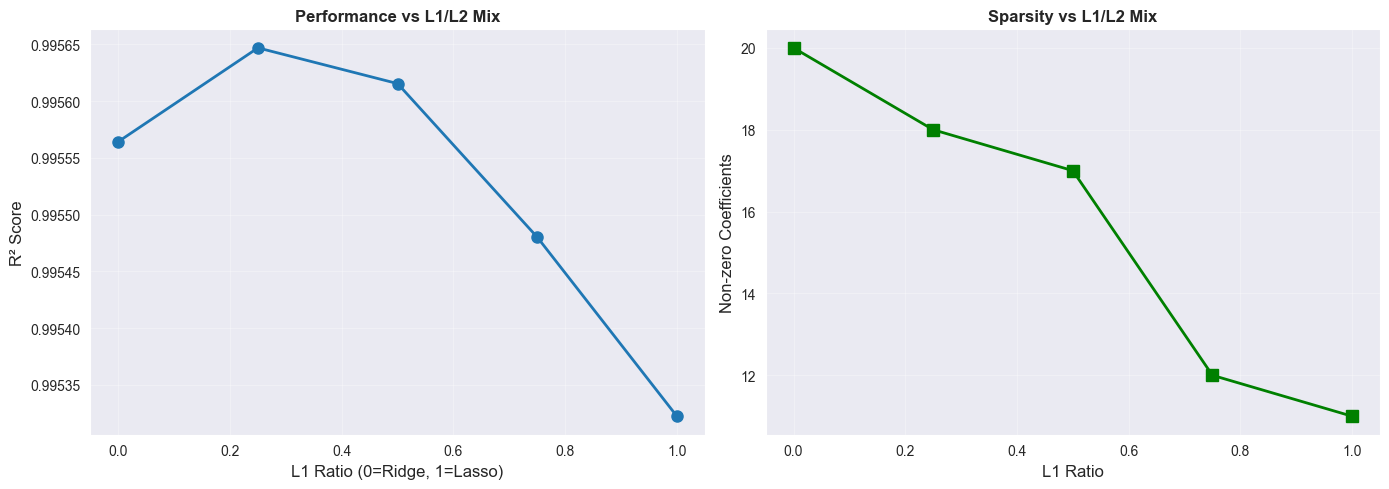

Higher L1 ratio → more sparsity (feature selection)


In [5]:
l1_ratios = [0, 0.25, 0.5, 0.75, 1.0]
non_zero_counts = []
r2_scores = []

for ratio in l1_ratios:
    en = ElasticNet(alpha=1.0, l1_ratio=ratio)
    en.fit(X_train_scaled, y_train)
    pred = en.predict(X_test_scaled)
    
    non_zero_counts.append(np.sum(np.abs(en.weights) > 1e-5))
    r2_scores.append(r2_score(y_test, pred))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(l1_ratios, r2_scores, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('L1 Ratio (0=Ridge, 1=Lasso)', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Performance vs L1/L2 Mix', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(l1_ratios, non_zero_counts, 's-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('L1 Ratio', fontsize=12)
axes[1].set_ylabel('Non-zero Coefficients', fontsize=12)
axes[1].set_title('Sparsity vs L1/L2 Mix', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Higher L1 ratio → more sparsity (feature selection)')

---
## Summary

**Key Points:**
- Elastic Net = Ridge + Lasso 
- l1_ratio controls mix: 0=Ridge, 1=Lasso
- Gets benefits of both: stability + sparsity
- Best for correlated features with feature selection

**Key Point:** "Elastic Net combines L1 and L2 penalties, balancing Ridge's stability with correlated features and Lasso's feature selection. The l1_ratio parameter controls the mix."